Image: /content/drive/MyDrive/ShanghaiTech/part_A/train_data/images/IMG_110.jpg, Annotations: 228 points


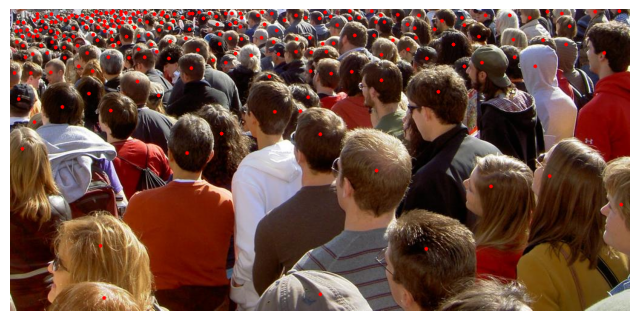

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import scipy.io as sio
import torch

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class CrowdDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "images")
        self.gt_dir = os.path.join(root_dir, "ground-truth")
        self.image_paths = [os.path.join(self.image_dir, img)
                            for img in os.listdir(self.image_dir) if img.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        filename = os.path.basename(img_path).replace(".jpg", ".mat")
        gt_filename = "GT_" + filename
        gt_path = os.path.join(self.gt_dir, gt_filename)

        if not os.path.exists(gt_path):
            raise FileNotFoundError(f"Ground truth file not found for {img_path}")

        image = Image.open(img_path).convert("RGB")

        mat = sio.loadmat(gt_path)
        points = mat["image_info"][0, 0][0, 0][0]

        if self.transform:
            image = self.transform(image)

        return image, points.tolist(), img_path

def visualize_sample(img_path, points, save_path=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for point in points:
        x, y = int(point[0]), int(point[1])
        cv2.circle(img, (x, y), 3, (255, 0, 0), -1)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def custom_collate(batch):
    images, points, paths = zip(*batch)
    return torch.stack(images, 0), list(points), list(paths)

if __name__ == "__main__":
    dataset_path = r"/content/drive/MyDrive/ShanghaiTech/part_A/train_data"
    dataset = CrowdDataset(root_dir=dataset_path, transform=transform)

    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)

    for img_tensor, points, img_path in dataloader:
        sample_img_path = img_path[0]
        sample_points = points[0]
        print(f"Image: {sample_img_path}, Annotations: {len(sample_points)} points")

        visualize_sample(sample_img_path, sample_points, save_path="visualizations/sample.png")
        break